#### Annotate  and Enhance Datasets (Ocular Dataset and ODIR5k)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os 
import io
import itertools

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# visualization dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.graph_objects as go
import plotly.offline as pyo

from plotly.offline import iplot, plot
from plotly.offline import init_notebook_mode

import cufflinks as cf
import warnings

warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=False, world_readable=False)

sns.set(style='whitegrid', palette='muted',
       rc={'figure.figsize': (16, 16)})
plt.rcParams['figure.dpi'] = 120.0

init_notebook_mode(connected=False)

In [2]:
NUM_EPOCHS = 150
BATCH_SIZE = 64
LR = 1e-4
IMG_SIZE = 256

In [3]:
import shutil

def clear_content(directory):
    for img in os.listdir(directory):
        file_path = os.path.join(directory, img)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Execption as exc:
            raise("Failed to delete: %s %s" % (file_path, exc))

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/component/requirejs/require.js"></script>
        <script>
            requirejs.config({
                path: {
                    base: '/static/base',
                    plotly: 'https://cdn.plot.ly/plotly.1.5.1.min.js?noext'
                },
            });
        </script>
    '''))

#### Annotation of Ocular Dataset

In [4]:
occ_annotate = pd.DataFrame({
    'filename': ['NL'],
    'N': [1],
    'C': [0],
    'G': [0],
    'M': [0]
}, dtype='object')
occ_annotate.infer_objects()

i = 0
dataset_path = "../../assets/datasets/dataset"
# occ_annotate['filename'][0] = 1
for class_dir in os.listdir(dataset_path)[:3]:
    class_dir_path = os.path.join(dataset_path, class_dir)
    for img in os.listdir(class_dir_path):
        img_path = os.path.join(class_dir_path, img)
        occ_annotate.loc[i, 'filename'] = img
        if 'normal' in class_dir:
            occ_annotate.loc[i, 'N'] = 1
            occ_annotate.loc[i, 'C'] = 0
            occ_annotate.loc[i, 'G'] = 0
            occ_annotate.loc[i, 'M'] = 0
        if 'cataract' in class_dir:
            occ_annotate.loc[i, 'N'] = 0
            occ_annotate.loc[i, 'C'] = 1
            occ_annotate.loc[i, 'G'] = 0
            occ_annotate.loc[i, 'M'] = 0
        if 'glaucoma' in class_dir:
            occ_annotate.loc[i, 'N'] = 0
            occ_annotate.loc[i, 'C'] = 0
            occ_annotate.loc[i, 'G'] = 1
            occ_annotate.loc[i, 'M'] = 0
        i = i + 1


occ_annotate.to_csv("ocular_disease_annotation.csv", index=False)
occ_annotate.head()

filename  N  C  G  M
0  NL_001.png  1  0  0  0
1  NL_002.png  1  0  0  0
2  NL_003.png  1  0  0  0
3  NL_004.png  1  0  0  0
4  NL_005.png  1  0  0  0

In [5]:
# occ_annotate.loc[1, 'N'] = 1
occ_annotate.astype({
    'N': int,
    'C': int,
    'G': int,
    'M': int
})
occ_annotate[['N', 'C', 'G', 'M']] = occ_annotate[['N', 'C', 'G', 'M']].apply(pd.to_numeric)
type(occ_annotate.loc[0, 'N'])

numpy.int64

In [6]:
paths = ['odir5k', 'dataset']

for path in paths:
    for dirname, subfolders, filenames in os.walk("../../assets/datasets/" + path):
        for subf in subfolders:
            print(os.path.join(dirname, subf))

../../assets/datasets/odir5k\ODIR-5K
../../assets/datasets/odir5k\preprocessed_images
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Testing Images
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Training Images
../../assets/datasets/dataset\1_normal
../../assets/datasets/dataset\2_cataract
../../assets/datasets/dataset\2_glaucoma
../../assets/datasets/dataset\3_retina_disease


### Step 1: Load and Explore the Dataset

In [4]:
import glob
occ_path = "../../assets/datasets/dataset"
occ_annot = "ocular_disease_annotation.csv"
test_folder = "datazet-again"
class_dirs = os.listdir(occ_path)[:3]

#### Visualize Few Fundus Images

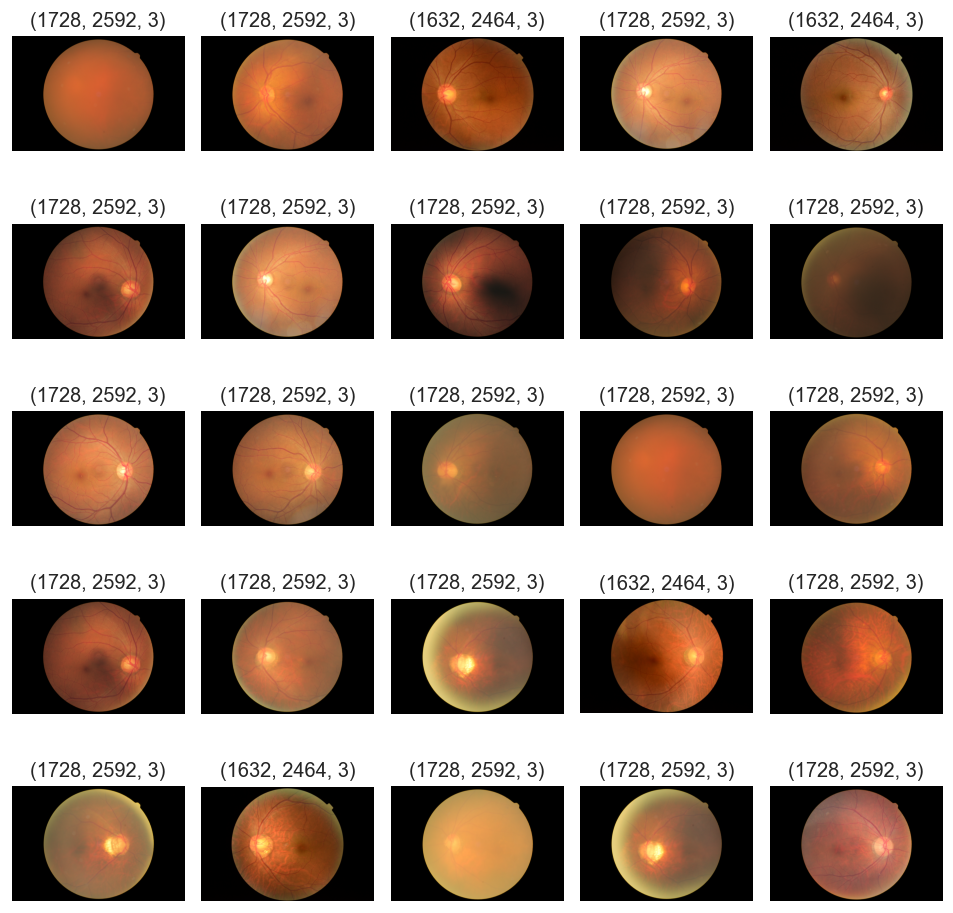

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(25):
    rand_dir = np.random.randint(0, len(class_dirs))
    rand_dir_path = os.path.join(occ_path, class_dirs[rand_dir])
    rand_idx = np.random.randint(0, len(rand_dir_path))
    img_file = os.path.join(rand_dir_path, os.listdir(rand_dir_path)[rand_idx])
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(f"{image.shape}")
    plt.axis('off')
    plt.grid(False)
plt.show()

#### Exploratory Data Analysis

In [46]:
# df.iloc[:,1:4].sum().index

In [9]:
def data_mapping(df, initial):
    labels = []
    fundus_names = df.iloc[:, 0]
    
    for i in range(len(fundus_names)):
        labels.append(initial)
    labels.append('M')
    return labels

def count_labels(df):
    labels = df.iloc[:, 1:5].sum().index
    total_count = []
    labels_count = []
    
    for i in range(len(labels)):
        label_count = data_mapping(df.loc[(df[labels[i]] == 1)], labels[i])
        total_count += label_count
        labels_count.append(len(total_count))
        print(f"{labels[i]}: {len(label_count)}")
    return total_count, labels_count

In [10]:
annot_df = pd.read_csv(occ_annot)
annot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  501 non-null    object
 1   N         501 non-null    int64 
 2   C         501 non-null    int64 
 3   G         501 non-null    int64 
 4   M         501 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 19.7+ KB


In [11]:
total_count, labels_count = count_labels(annot_df)
print(len(total_count))

N: 301
C: 101
G: 102
M: 1
505


In [12]:
labels_ser = pd.Series(total_count, name='label')

labels_df = pd.DataFrame({
    'labels': labels_ser.value_counts().index,
    'count': labels_ser.value_counts()
})

label_counts = sorted(labels_count, reverse=True)
labels_df['percentage'] = [float(i / sum(label_counts)) for i in label_counts]
print(labels_df['percentage'])

fig = plt.figure(figsize=(16, 16))
fig = go.Figure(data=[go.Bar(
                x=labels_df['labels'],
                y=labels_df['count'],
                text=labels_df['percentage'].apply(lambda x: "{0:1.2f}%".format(x * 100)),
                textposition = 'auto',
                marker=dict(
                    colorscale='Viridis'
                )
                )])

fig.update_layout(
    title='Fundus Image Distribution',
    xaxis_title='disease',
    yaxis_title='count',
    font=dict(
        size=14
    )
)

fig.show()

N    0.294977
G    0.294393
C    0.234813
M    0.175818
Name: percentage, dtype: float64


<Figure size 1920x1920 with 0 Axes>

### Step 2: Data Preprocessing

**Crop Contour Method 1: Without Edge Detection**

In [14]:
import imutils

def crop_contour_fundus_image(image, plot=False, image_size=(256, 256)):
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayed = cv2.GaussianBlur(grayed, (5,5), 0)
#     thresh_image = cv2.threshold(grayed, 65, 255, cv2.THRESH_BINARY)[1]
    thresh_image = cv2.erode(grayed, None, iterations=2)
    thresh_image = cv2.dilate(thresh_image, None, iterations=2)
    
    # find contours
    contours = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    
    # extract bounding coords from largest contour
    extreme_pnts_left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop image
    new_image = grayed[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    
    # apply adaptive equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    equalized = clahe.apply(new_image)
    
    # apply image normalization
    mask = np.zeros((256, 256))
    normalized = cv2.normalize(equalized, mask, 0, 255, cv2.NORM_MINMAX)
    
    # resize image
    new_image = cv2.resize(normalized, image_size, interpolation=cv2.INTER_AREA)

    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # --------------------------- #
        
        plt.subplot(1,2,2)
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
#         plt.imshow(new_image)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        plt.show()
        
    return new_image

**Crop Contour Method 2: With Edge Detection**

In [15]:
def crop_contour_retinal_image(image, plot=False, image_size=(256, 256)):
    image = cv2.resize(image, None, fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grayed = cv2.GaussianBlur(grayed, (5,5), 0)
    thresh_image = cv2.erode(grayed, None, iterations=2)
    thresh_image = cv2.dilate(thresh_image, None, iterations=2)
    
    #find canny edges
    edges = cv2.Canny(thresh_image, 20, 70)
    
    # find contours
    contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    
    # extract bounding coords rom largest contour
    extreme_pnts_left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop image
    new_image = grayed[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    new_image = cv2.resize(new_image, image_size, interpolation=cv2.INTER_AREA)
    
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # ---------------------- #
        
        plt.subplot(1,2,2)
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        plt.show()
        
    return new_image

**Method 3: Crop only and Resize Image**
* Leaves image as RGB

In [5]:
def crop_image(image, plot=False, image_size=(256, 256)):
    # mask of colored pixels
    mask = image > 40
    
    # coordinates of colored pixels
    coordinates = np.argwhere(mask)
    
    # binding box of non-black pixels
    x0, y0, s0 = coordinates.min(axis=0)
    x1, y1, s1 = coordinates.max(axis=0) + 1 # slices are exclusive at the top
    
    # get the content of the bouding box
    cropped = image[x0:x1, y0:y1]
    
    # convert to COLOR_RGB2YUV for equalization
    img_yuv = cv2.cvtColor(cropped, cv2.COLOR_RGB2YUV)
    
    # apply adaptive equalization on colored image
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    
    # apply image normalization on colored image
    mask = np.zeros((256, 256))
    normalized = cv2.normalize(img_yuv[:, :, 0], mask, 0, 255, cv2.NORM_MINMAX)
    
    new_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    new_image = cv2.resize(new_image, image_size, interpolation=cv2.INTER_AREA)
    
    # must convert back to BGR to have it saved as RGB
    # cv2 just swaps channels when loaded hence BGR when shown
    # only converted to RGB for visualization purposes
    # but will be converted to BGR again to be saved as RGB
    final_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # -------------- #
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis("off")
        plt.grid(False)
        
        plt.show()
        
    return final_image

In [19]:
def crop_image_cv(image, plot=False, image_size=(256, 256)):
    # mask of colored pixels
    mask = image > 40
    
    # coordinates of colored pixels
    coordinates = np.argwhere(mask)
    
    # binding box of non-black pixels
    x0, y0, s0 = coordinates.min(axis=0)
    x1, y1, s1 = coordinates.max(axis=0) + 1 # slices are exclusive at the top
    
    # get the content of the bouding box
    cropped = image[x0:x1, y0:y1]
    new_image = cv2.resize(cropped, image_size, interpolation=cv2.INTER_AREA)
    
    # must convert back to BGR to have it saved as RGB
    # cv2 just swaps channels when loaded hence BGR when shown
    # only converted to RGB for visualization purposes
    # but will be converted to BGR again to be saved as RGB
    final_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # -------------- #
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis("off")
        plt.grid(False)
        
        plt.show()
        
    return final_image

In [16]:
import os

def crop_image_only(image, plot=False, image_size=(256, 256)):
    width, height, = image.size
    
    offset = int(abs(height-width)/2)
    
    if width > height:
        new_image = image.crop([offset, 0, width-offset, height])
    else:
        new_image = image.crop([0, offset, width, height-offset])
    new_image.resize(256, 256)
    
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # -------------- #
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis("off")
        plt.grid(False)
        
        plt.show()
        
    return new_image

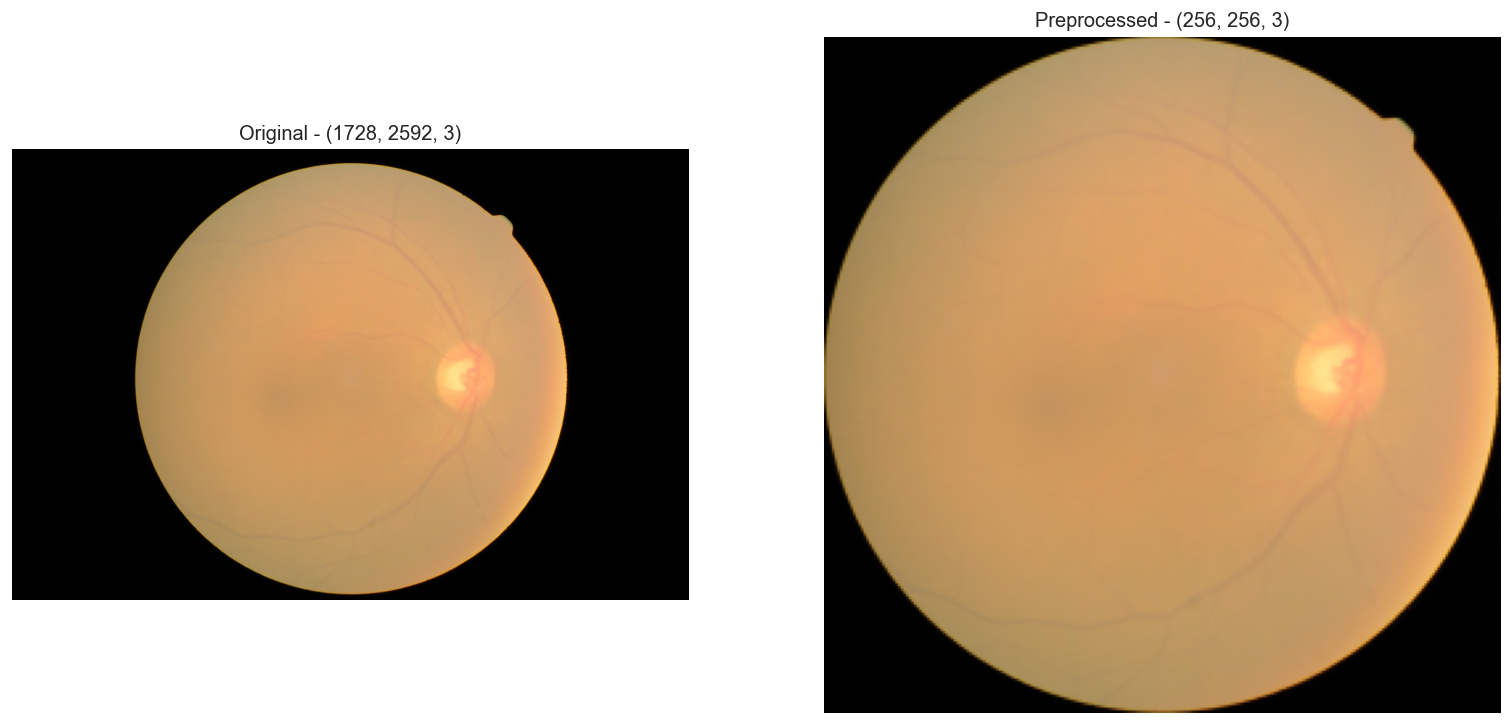

In [21]:
import traceback

try:
    rand_dir = np.random.randint(0, len(class_dirs))
    rand_dir_path = os.path.join(occ_path, class_dirs[rand_dir])
    rand_idx = np.random.randint(0, len(os.listdir(rand_dir_path)))
    img_file = os.path.join(rand_dir_path, os.listdir(rand_dir_path)[rand_idx])
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = Image.open(img_file)
#     image = image.convert("RGB")
    new_image = crop_image_cv(image, plot=True, image_size=(IMG_SIZE, IMG_SIZE))
#     new_image = crop_image_only(image)
except Exception as exc:
    traceback.print_tb(exc.__traceback__)

#### Preprocess Raw Images

In [18]:
# train_output = "occ_preprocessed"

# if os.path.isdir(train_output):
#     clear_content(train_output)
# else:
#     os.mkdir(train_output)
    
# train_prep_images = []
# try:
#     for class_dir in class_dirs:
#         class_dir_path = os.path.join(occ_path, class_dir)
#         for img in os.listdir(class_dir_path):
#             file_path = os.path.join(class_dir_path, img)
#             if os.path.isfile(file_path):
#                 image = cv2.imread(file_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 new_image = crop_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
# #                 new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
#                 new_img_path = os.path.join(train_output, img)
# #                 cv2.imwrite(new_img_path, new_image)
#                 train_prep_images.append(new_img_path)
# except Exception as exc:
#     traceback.print_tb(exc.__traceback__)
    
# print("Train: ", len(train_prep_images))

In [23]:
folders = ['normal', 'cataract', 'myopia', 'glaucoma']
import shutil
import traceback
img_output = "datazet"
test_images_loc = []

if os.path.isdir(img_output):
    clear_content(img_output)
else:
    os.mkdir(img_output)

def remove_non_img(direc):
    for file in os.listdir(direc):
        file_path = os.path.join(direc, file)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        elif os.path.isfile(file_path):
            if not file_path.endswith('.png') and not file_path.endswith('.JPG'):
                os.unlink(file_path)
                
for n in range(4):
    direc = os.path.join(test_folder, folders[n])
    remove_non_img(direc)

for n in range(4):
    dir_path = os.path.join(test_folder, folders[n])
    try:
        for file in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            if os.path.isfile(file_path):
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                new_image = crop_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
                
                if folders[n] == 'normal':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

                elif folders[n] == 'cataract':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                elif folders[n] == 'myopia':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                elif folders[n] == 'glaucoma':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                test_images_loc.append(new_image_path)
    except Exception as exc:
        traceback.print_tb(exc.__traceback__)

print("Count: ", len(test_images_loc))
            

Count:  200


**Crop Image Only (No Enhancement)**

In [22]:
folders = ['normal', 'cataract', 'myopia', 'glaucoma']
import shutil
import traceback
from PIL import Image
img_output = "datazet_cropped"
test_images_loc = []

if os.path.isdir(img_output):
    clear_content(img_output)
else:
    os.mkdir(img_output)

def remove_non_img(direc):
    for file in os.listdir(direc):
        file_path = os.path.join(direc, file)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        elif os.path.isfile(file_path):
            if not file_path.endswith('.png') and not file_path.endswith('.JPG'):
                os.unlink(file_path)
                
for n in range(4):
    direc = os.path.join(test_folder, folders[n])
    remove_non_img(direc)

for n in range(4):
    dir_path = os.path.join(test_folder, folders[n])
    try:
        for file in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            if os.path.isfile(file_path):
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                new_image = crop_image_cv(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
#                 image = Image.open(file_path)
#                 new_image = crop_image_only(image)
#                 new_image = new_image.convert("RGB")
        
                if folders[n] == 'normal':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
#                     new_image.save(new_image_path)
    
                elif folders[n] == 'cataract':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
#                     new_image.save(new_image_path)

                elif folders[n] == 'myopia':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
#                     new_image.save(new_image_path)

                elif folders[n] == 'glaucoma':
                    folder_path = os.path.join(img_output, folders[n])
                    new_image_path = os.path.join(folder_path,file.split('.')[0] + '.jpg')
                    if not os.path.exists(folder_path):
                        os.makedirs(os.path.join(img_output, folders[n]))

                    cv2.imwrite(new_image_path, new_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
#                     new_image.save(new_image_path)

                test_images_loc.append(new_image_path)
    except Exception as exc:
        traceback.print_tb(exc.__traceback__)

print("Count: ", len(test_images_loc))
            

Count:  200


**Convert PNG files to JPG**

In [28]:
train_output = "occ_preprocessed"
train_output_jpg = "occ_preprocessed_jpg"

# if os.path.exists(train_output_jpg):
#     if len(os.listdir(train_output_jpg)) < 100:
#         clear_content(train_output_jpg)
# else:
#     os.mkdir(train_output_jpg)

train_jpg_files = []

for img in os.listdir(train_output):
    img_path = os.path.join(train_output, img)
    image = cv2.imread(img_path)
    img_jpg_path = os.path.join(train_output_jpg, img.split('.')[0] + '.jpg')
    cv2.imwrite(img_jpg_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    train_jpg_files.append(img_jpg_path)
    
print(len(train_jpg_files))

501


In [25]:
print(train_jpg_files[0])

occ_preprocessed_jpg\cataract_001.jpg


**Visualize Preprocessed JPG Images**

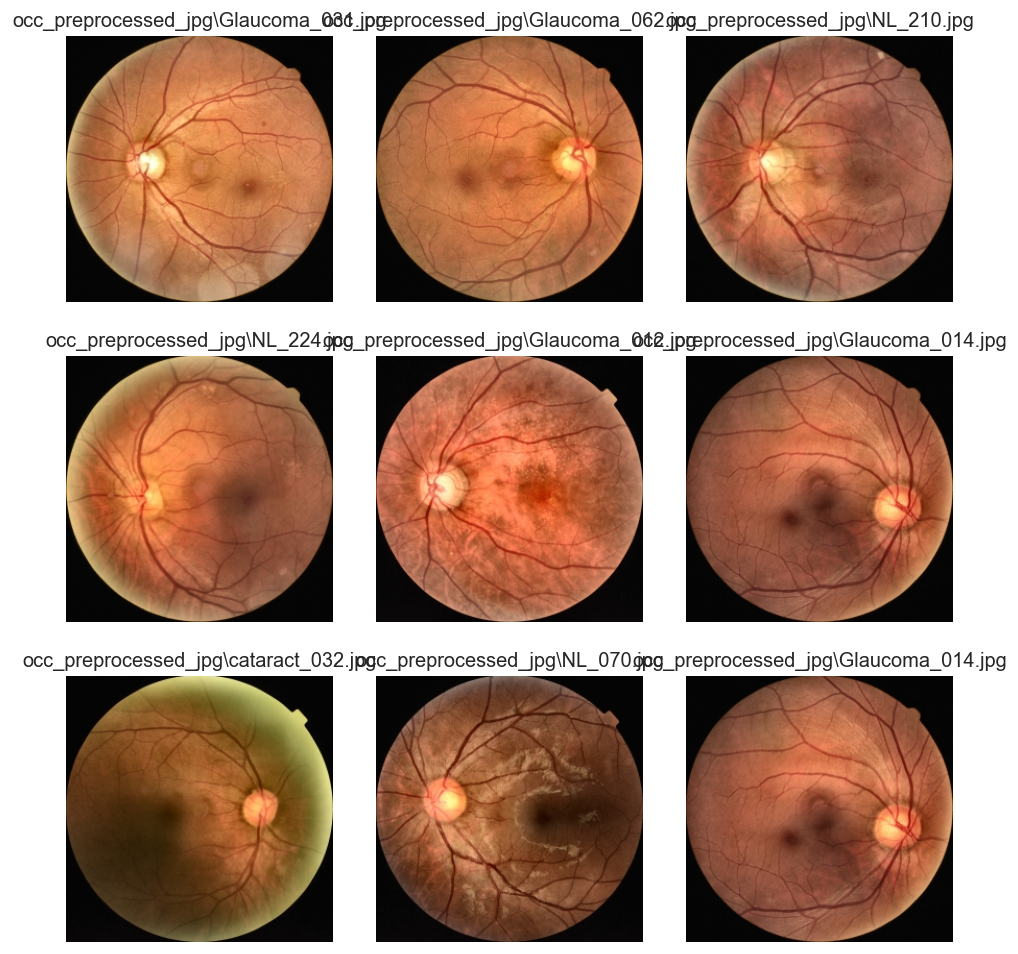

In [33]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0.2)

for i in range(9):
    rand_idx = np.random.randint(0, len(os.listdir(train_output)))
    img_file = train_jpg_files[rand_idx]
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title(f"{img_file.split('/')[0]}")
    plt.axis('off')
    plt.grid(False)
    
plt.show()

**Reannotate**

In [111]:
occ_reannotate = pd.DataFrame({
    'filename': ['NL'],
    'N': [1],
    'C': [0],
    'G': [0],
    'M': [0]
}, dtype='object')
occ_reannotate.infer_objects()

i = 0
dataset_path = "../../assets/datasets/dataset"
# occ_annotate['filename'][0] = 1
for class_dir in os.listdir(dataset_path)[:3]:
    class_dir_path = os.path.join(dataset_path, class_dir)
    for img in os.listdir(class_dir_path):
        img_path = os.path.join(class_dir_path, img)
        occ_reannotate.loc[i, 'filename'] = img.split('.')[0] + '.jpg'
        if 'normal' in class_dir:
            occ_reannotate.loc[i, 'N'] = 1
            occ_reannotate.loc[i, 'C'] = 0
            occ_reannotate.loc[i, 'G'] = 0
            occ_reannotate.loc[i, 'M'] = 0
        if 'cataract' in class_dir:
            occ_reannotate.loc[i, 'N'] = 0
            occ_reannotate.loc[i, 'C'] = 1
            occ_reannotate.loc[i, 'G'] = 0
            occ_reannotate.loc[i, 'M'] = 0
        if 'glaucoma' in class_dir:
            occ_reannotate.loc[i, 'N'] = 0
            occ_reannotate.loc[i, 'C'] = 0
            occ_reannotate.loc[i, 'G'] = 1
            occ_reannotate.loc[i, 'M'] = 0
        i = i + 1


occ_reannotate.to_csv("ocular_disease_reannotation.csv", index=False)
occ_reannotate.head()

filename  N  C  G  M
0  NL_001.jpg  1  0  0  0
1  NL_002.jpg  1  0  0  0
2  NL_003.jpg  1  0  0  0
3  NL_004.jpg  1  0  0  0
4  NL_005.jpg  1  0  0  0

**Upsample Minorities**

In [13]:
def upsample_columns(df, max_size):
    df = df.sample(frac=1).reset_index(drop=True)
    perc = len(df)/max_size
    
    size = int(max_size - (perc * max_size))
    print("upsampled by: ", size)
    for i in range(size):
        rand_idx = np.random.randint(0, len(df))
        eye = df.at[rand_idx, 'filename']
        row = df.loc[df['filename'].str.match(eye)]
        
        if len(row) > 1:
            df = df.append(row.iloc[0], ignore_index=True)
        else:
            df = df.append(row, ignore_index=True)
            
    return df

In [22]:
annot_df = pd.read_csv("ocular_disease_reannotation.csv")

In [23]:
max_size = 400
df_glaucoma = upsample_columns(annot_df[annot_df['G'] == 1], max_size)
annot_df = annot_df.append(df_glaucoma)
df_cataract = upsample_columns(annot_df[annot_df['C'] == 1], max_size)
annot_df = annot_df.append(df_cataract)

upsampled by:  299
upsampled by:  300


In [24]:
annot_df.iloc[:, 1:5].sum()

N    300
C    500
G    501
M      0
dtype: int64

In [25]:
annot_df.to_csv("ocular_disease_annotation_upsample.csv", index=False)
annot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1301 non-null   object
 1   N         1301 non-null   int64 
 2   C         1301 non-null   int64 
 3   G         1301 non-null   int64 
 4   M         1301 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 61.0+ KB


In [123]:
annot_df.head()

filename  N  C  G  M
0  NL_001.jpg  1  0  0  0
1  NL_002.jpg  1  0  0  0
2  NL_003.jpg  1  0  0  0
3  NL_004.jpg  1  0  0  0
4  NL_005.jpg  1  0  0  0